In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Ghost Batch Normalization Class

In [0]:

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        #print("batch norm")
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        #print("Ghost batch norm",num_features)
        super().__init__(num_features, **kw)
        #print("Ghost batch norm...1...",num_features)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [0]:
dropout_value = 0
class Net(nn.Module):

    def __init__(self,batch_normalization=False,ghost_batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization        
        self.do_ghost_bn = ghost_batch_normalization 


        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 26, RF = 3
        if self.do_bn:
          self.conv1_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv1_ghost_bn = GhostBatchNorm(8,2)
                

        self.conv2 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False), nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 24, RF = 5
        if self.do_bn:
          self.conv2_bn = nn.BatchNorm2d(12) 
        elif self.do_ghost_bn:          
          self.conv2_ghost_bn = GhostBatchNorm(12,2)             


        self.conv3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(12, 8, 1, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 12, RF = 6
        if self.do_bn:   
          self.conv3_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv3_ghost_bn = GhostBatchNorm(8,2)              


        self.conv4 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False),nn.ReLU(inplace=True), nn.Dropout(dropout_value)) # output_size = 10, RF = 10
        if self.do_bn: 
          self.conv4_bn = nn.BatchNorm2d(12)
        elif self.do_ghost_bn:          
          self.conv4_ghost_bn = GhostBatchNorm(12,2)             


        self.conv5 = nn.Sequential(nn.Conv2d(12, 16, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 8, RF = 14
        if self.do_bn:
          self.conv5_bn = nn.BatchNorm2d(16)
        elif self.do_ghost_bn:          
          self.conv5_ghost_bn = GhostBatchNorm(16,2)             


        self.conv6 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 6, RF = 18
        if self.do_bn:
          self.conv6_bn = nn.BatchNorm2d(32)
        elif self.do_ghost_bn:          
          self.conv6_ghost_bn = GhostBatchNorm(32,2)               


        self.gap = nn.AvgPool2d(kernel_size=6) # output_size = 1, RF = 28
        self.conv7 = nn.Sequential(nn.Conv2d(32, 10, 1, padding=0, bias=False)) # output_size = 1, RF = 28


    def forward(self, x):

        # Model with Batch Normalization
        if self.do_bn: 
          x = self.conv1(x)
          x = self.conv1_bn(x)          
          x = self.conv2(x)
          x = self.conv2_bn(x)   
          x = self.conv3(x)
          x = self.conv3_bn(x)   
          x = self.conv4(x)
          x = self.conv4_bn(x)
          x = self.conv5(x)
          x = self.conv5_bn(x)
          x = self.conv6(x)
          x = self.conv6_bn(x)

        # Model with Ghost Batch Normalization
        elif self.do_ghost_bn:

          x = self.conv1(x)
          x = self.conv1_ghost_bn(x)          
          x = self.conv2(x)
          x = self.conv2_ghost_bn(x)   
          x = self.conv3(x)
          x = self.conv3_ghost_bn(x)   
          x = self.conv4(x)
          x = self.conv4_ghost_bn(x)
          x = self.conv5(x)
          x = self.conv5_ghost_bn(x)
          x = self.conv6(x)
          x = self.conv6_ghost_bn(x)

        else:
          x = self.conv1(x)
          x = self.conv2(x)
          x = self.conv3(x)
          x = self.conv4(x)
          x = self.conv5(x)
          x = self.conv6(x)
            

        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)
model2=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)
summary(model, input_size=(1, 28, 28))
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
           Dropout-3            [-1, 8, 26, 26]               0
       BatchNorm2d-4            [-1, 8, 26, 26]              16
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              96
             ReLU-11            [-1, 8, 12, 12]               0
          Dropout-12            [-1, 8, 12, 12]               0
      BatchNorm2d-13            [-1, 8, 12, 12]              16
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
def train_eval(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)

    print('\n\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
test_acc = []
train_acc = []
#final_test_results=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    print("length of test dataset",len(test_loader.dataset))
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #print("in Test...final losses",test_losses)
    #print("in Test...final accuracies",test_acc)
    final_test_results.append(test_losses)
    final_test_results.append(test_acc)
    
    return final_test_results

In [0]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for parameter in model.parameters():
      reg_loss += l1_crit(parameter, loss)
    factor = 0.00025
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    


In [30]:
from torch.optim.lr_scheduler import StepLR

BN_model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)
GBN_model=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)

# Training for 25 Epocs 
EPOCHS = 25
for i in range(8):
  for epoch in range(EPOCHS):
    if i == 0:
      print("CASE_1: without L1andL2 with BN")
      print("EPOCH:", epoch)     
      final_test_results=[] 
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(BN_model, device, train_loader, optimizer, epoch)
      results1 = test(BN_model, device, test_loader)
      

    elif i == 1:
      print("CASE_1: without L1andL2 with GBN")
      print("EPOCH:", epoch)      
      final_test_results=[]
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(GBN_model, device, train_loader, optimizer, epoch)
      results2 = test(GBN_model, device, test_loader)
      
    elif i == 2:
      print("CASE_2: with L1 with BN")
      print("EPOCH:", epoch)   
      final_test_results=[]   
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results3 = test(BN_model, device, test_loader)

    elif i == 3:
      print("CASE_3: with L1 with GBN")
      print("EPOCH:", epoch)    
      final_test_results=[]  
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(GBN_model, device, train_loader, optimizer, epoch)
      results4 = test(GBN_model, device, test_loader)


    elif i == 4:
      print("CASE_4: with L2 with BN")
      print("EPOCH:", epoch)   
      final_test_results=[]   
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(BN_model, device, train_loader, optimizer, epoch)
      results5 =test(BN_model, device, test_loader)

    elif i == 5:
      print("CASE_5: with L2 with GBN")
      print("EPOCH:", epoch)    
      final_test_results=[]  
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(GBN_model, device, train_loader, optimizer, epoch)
      results6 =test(GBN_model, device, test_loader)


    elif i ==6:
      print("CASE_6: with L1andL2 with BN")
      print("EPOCH:", epoch)     
      final_test_results=[] 
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results7 =test(BN_model, device, test_loader)    


    elif i ==7:
      print("CASE_7: with L1andL2 with GBN")
      print("EPOCH:", epoch)  
      final_test_results=[]    
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(GBN_model, device, train_loader, optimizer, epoch)
      results8 =test(GBN_model, device, test_loader)    


  0%|          | 0/469 [00:00<?, ?it/s]

CASE_1: without L1andL2 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.0693228617310524 Batch_id=468 Accuracy=89.84: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 9817/10000 (98.17%)

CASE_1: without L1andL2 with BN
EPOCH: 1


Loss=0.07071768492460251 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9837/10000 (98.37%)

CASE_1: without L1andL2 with BN
EPOCH: 2


Loss=0.1359933763742447 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 31.27it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9889/10000 (98.89%)

CASE_1: without L1andL2 with BN
EPOCH: 3


Loss=0.01490795612335205 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9873/10000 (98.73%)

CASE_1: without L1andL2 with BN
EPOCH: 4


Loss=0.06975262612104416 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9913/10000 (99.13%)

CASE_1: without L1andL2 with BN
EPOCH: 5


Loss=0.0147622125223279 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9889/10000 (98.89%)

CASE_1: without L1andL2 with BN
EPOCH: 6


Loss=0.026332296431064606 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9907/10000 (99.07%)

CASE_1: without L1andL2 with BN
EPOCH: 7


Loss=0.037858571857213974 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9916/10000 (99.16%)

CASE_1: without L1andL2 with BN
EPOCH: 8


Loss=0.03856881335377693 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9903/10000 (99.03%)

CASE_1: without L1andL2 with BN
EPOCH: 9


Loss=0.020321249961853027 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)

CASE_1: without L1andL2 with BN
EPOCH: 10


Loss=0.0575687550008297 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

CASE_1: without L1andL2 with BN
EPOCH: 11


Loss=0.012985874898731709 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9908/10000 (99.08%)

CASE_1: without L1andL2 with BN
EPOCH: 12


Loss=0.017899692058563232 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

CASE_1: without L1andL2 with BN
EPOCH: 13


Loss=0.04933861270546913 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9913/10000 (99.13%)

CASE_1: without L1andL2 with BN
EPOCH: 14


Loss=0.023359840735793114 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9911/10000 (99.11%)

CASE_1: without L1andL2 with BN
EPOCH: 15


Loss=0.015924977138638496 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

CASE_1: without L1andL2 with BN
EPOCH: 16


Loss=0.010279555805027485 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

CASE_1: without L1andL2 with BN
EPOCH: 17


Loss=0.01233913004398346 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

CASE_1: without L1andL2 with BN
EPOCH: 18


Loss=0.004079242702573538 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

CASE_1: without L1andL2 with BN
EPOCH: 19


Loss=0.015516340732574463 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

CASE_1: without L1andL2 with BN
EPOCH: 20


Loss=0.013288344256579876 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99.26%)

CASE_1: without L1andL2 with BN
EPOCH: 21


Loss=0.04062996804714203 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

CASE_1: without L1andL2 with BN
EPOCH: 22


Loss=0.027635836973786354 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

CASE_1: without L1andL2 with BN
EPOCH: 23


Loss=0.031217018142342567 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

CASE_1: without L1andL2 with BN
EPOCH: 24


Loss=0.10990040749311447 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

CASE_1: without L1andL2 with GBN
EPOCH: 0


Loss=0.07886796444654465 Batch_id=468 Accuracy=89.21: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9788/10000 (97.88%)

CASE_1: without L1andL2 with GBN
EPOCH: 1


Loss=0.08451349288225174 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9851/10000 (98.51%)

CASE_1: without L1andL2 with GBN
EPOCH: 2


Loss=0.10590562969446182 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9833/10000 (98.33%)

CASE_1: without L1andL2 with GBN
EPOCH: 3


Loss=0.043283987790346146 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9878/10000 (98.78%)

CASE_1: without L1andL2 with GBN
EPOCH: 4


Loss=0.031138166785240173 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9914/10000 (99.14%)

CASE_1: without L1andL2 with GBN
EPOCH: 5


Loss=0.026169786229729652 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9893/10000 (98.93%)

CASE_1: without L1andL2 with GBN
EPOCH: 6


Loss=0.05387159064412117 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

CASE_1: without L1andL2 with GBN
EPOCH: 7


Loss=0.028399473056197166 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.09%)

CASE_1: without L1andL2 with GBN
EPOCH: 8


Loss=0.04006450995802879 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9938/10000 (99.38%)

CASE_1: without L1andL2 with GBN
EPOCH: 9


Loss=0.019056200981140137 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

CASE_1: without L1andL2 with GBN
EPOCH: 10


Loss=0.016877824440598488 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

CASE_1: without L1andL2 with GBN
EPOCH: 11


Loss=0.042857587337493896 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9927/10000 (99.27%)

CASE_1: without L1andL2 with GBN
EPOCH: 12


Loss=0.0297244880348444 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

CASE_1: without L1andL2 with GBN
EPOCH: 13


Loss=0.008279417641460896 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

CASE_1: without L1andL2 with GBN
EPOCH: 14


Loss=0.06586185842752457 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.22%)

CASE_1: without L1andL2 with GBN
EPOCH: 15


Loss=0.007172077894210815 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

CASE_1: without L1andL2 with GBN
EPOCH: 16


Loss=0.03765009343624115 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)

CASE_1: without L1andL2 with GBN
EPOCH: 17


Loss=0.053474411368370056 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

CASE_1: without L1andL2 with GBN
EPOCH: 18


Loss=0.014973551034927368 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

CASE_1: without L1andL2 with GBN
EPOCH: 19


Loss=0.03721781075000763 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

CASE_1: without L1andL2 with GBN
EPOCH: 20


Loss=0.019078552722930908 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

CASE_1: without L1andL2 with GBN
EPOCH: 21


Loss=0.0038106441497802734 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

CASE_1: without L1andL2 with GBN
EPOCH: 22


Loss=0.005424370523542166 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

CASE_1: without L1andL2 with GBN
EPOCH: 23


Loss=0.05808119475841522 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

CASE_1: without L1andL2 with GBN
EPOCH: 24


Loss=0.00372903048992157 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

CASE_2: with L1 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) 

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

CASE_2: with L1 with BN
EPOCH: 1


Loss=0.27863577008247375 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9916/10000 (99.16%)

CASE_2: with L1 with BN
EPOCH: 2


Loss=0.2967374920845032 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

CASE_2: with L1 with BN
EPOCH: 3


Loss=0.1822393387556076 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9897/10000 (98.97%)

CASE_2: with L1 with BN
EPOCH: 4


Loss=0.20488499104976654 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

CASE_2: with L1 with BN
EPOCH: 5


Loss=0.20911270380020142 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

CASE_2: with L1 with BN
EPOCH: 6


Loss=0.17297513782978058 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9905/10000 (99.05%)

CASE_2: with L1 with BN
EPOCH: 7


Loss=0.16738474369049072 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9864/10000 (98.64%)

CASE_2: with L1 with BN
EPOCH: 8


Loss=0.26324033737182617 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9871/10000 (98.71%)

CASE_2: with L1 with BN
EPOCH: 9


Loss=0.17688925564289093 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9897/10000 (98.97%)

CASE_2: with L1 with BN
EPOCH: 10


Loss=0.1728454828262329 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9911/10000 (99.11%)

CASE_2: with L1 with BN
EPOCH: 11


Loss=0.24750888347625732 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9900/10000 (99.00%)

CASE_2: with L1 with BN
EPOCH: 12


Loss=0.16303902864456177 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9907/10000 (99.07%)

CASE_2: with L1 with BN
EPOCH: 13


Loss=0.17251211404800415 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9904/10000 (99.04%)

CASE_2: with L1 with BN
EPOCH: 14


Loss=0.44380584359169006 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)

CASE_2: with L1 with BN
EPOCH: 15


Loss=0.1944815218448639 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9871/10000 (98.71%)

CASE_2: with L1 with BN
EPOCH: 16


Loss=0.15887629985809326 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

CASE_2: with L1 with BN
EPOCH: 17


Loss=0.21947695314884186 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9885/10000 (98.85%)

CASE_2: with L1 with BN
EPOCH: 18


Loss=0.15951035916805267 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9892/10000 (98.92%)

CASE_2: with L1 with BN
EPOCH: 19


Loss=0.19118523597717285 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9906/10000 (99.06%)

CASE_2: with L1 with BN
EPOCH: 20


Loss=0.2282162308692932 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9898/10000 (98.98%)

CASE_2: with L1 with BN
EPOCH: 21


Loss=0.17369477450847626 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9886/10000 (98.86%)

CASE_2: with L1 with BN
EPOCH: 22


Loss=0.24119143187999725 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9830/10000 (98.30%)

CASE_2: with L1 with BN
EPOCH: 23


Loss=0.1700279861688614 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9874/10000 (98.74%)

CASE_2: with L1 with BN
EPOCH: 24


Loss=0.3631562888622284 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9894/10000 (98.94%)

CASE_3: with L1 with GBN
EPOCH: 0


Loss=0.21122799813747406 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

CASE_3: with L1 with GBN
EPOCH: 1


Loss=0.21241120994091034 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9913/10000 (99.13%)

CASE_3: with L1 with GBN
EPOCH: 2


Loss=0.34057337045669556 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9905/10000 (99.05%)

CASE_3: with L1 with GBN
EPOCH: 3


Loss=0.22508329153060913 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

CASE_3: with L1 with GBN
EPOCH: 4


Loss=0.2153346687555313 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9905/10000 (99.05%)

CASE_3: with L1 with GBN
EPOCH: 5


Loss=0.26647305488586426 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

CASE_3: with L1 with GBN
EPOCH: 6


Loss=0.23822441697120667 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)

CASE_3: with L1 with GBN
EPOCH: 7


Loss=0.2090759426355362 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

CASE_3: with L1 with GBN
EPOCH: 8


Loss=0.17595161497592926 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9904/10000 (99.04%)

CASE_3: with L1 with GBN
EPOCH: 9


Loss=0.18233923614025116 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9861/10000 (98.61%)

CASE_3: with L1 with GBN
EPOCH: 10


Loss=0.17152753472328186 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)

CASE_3: with L1 with GBN
EPOCH: 11


Loss=0.16964642703533173 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9905/10000 (99.05%)

CASE_3: with L1 with GBN
EPOCH: 12


Loss=0.31364116072654724 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9893/10000 (98.93%)

CASE_3: with L1 with GBN
EPOCH: 13


Loss=0.22274735569953918 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

CASE_3: with L1 with GBN
EPOCH: 14


Loss=0.1862277388572693 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9902/10000 (99.02%)

CASE_3: with L1 with GBN
EPOCH: 15


Loss=0.16210311651229858 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)

CASE_3: with L1 with GBN
EPOCH: 16


Loss=0.3167811930179596 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9900/10000 (99.00%)

CASE_3: with L1 with GBN
EPOCH: 17


Loss=0.19235511124134064 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

CASE_3: with L1 with GBN
EPOCH: 18


Loss=0.16056302189826965 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9924/10000 (99.24%)

CASE_3: with L1 with GBN
EPOCH: 19


Loss=0.1722627580165863 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9881/10000 (98.81%)

CASE_3: with L1 with GBN
EPOCH: 20


Loss=0.15959185361862183 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

CASE_3: with L1 with GBN
EPOCH: 21


Loss=0.1666063368320465 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)

CASE_3: with L1 with GBN
EPOCH: 22


Loss=0.2027299702167511 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

CASE_3: with L1 with GBN
EPOCH: 23


Loss=0.22687667608261108 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9911/10000 (99.11%)

CASE_3: with L1 with GBN
EPOCH: 24


Loss=0.16367588937282562 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9900/10000 (99.00%)

CASE_4: with L2 with BN
EPOCH: 0


Loss=0.008097459562122822 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

CASE_4: with L2 with BN
EPOCH: 1


Loss=0.012999147176742554 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

CASE_4: with L2 with BN
EPOCH: 2


Loss=0.007504900451749563 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

CASE_4: with L2 with BN
EPOCH: 3


Loss=0.08120010048151016 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

CASE_4: with L2 with BN
EPOCH: 4


Loss=0.013659941963851452 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

CASE_4: with L2 with BN
EPOCH: 5


Loss=0.019337231293320656 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9920/10000 (99.20%)

CASE_4: with L2 with BN
EPOCH: 6


Loss=0.01433531939983368 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

CASE_4: with L2 with BN
EPOCH: 7


Loss=0.010334263555705547 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

CASE_4: with L2 with BN
EPOCH: 8


Loss=0.03647033870220184 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

CASE_4: with L2 with BN
EPOCH: 9


Loss=0.03784719109535217 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

CASE_4: with L2 with BN
EPOCH: 10


Loss=0.006330867763608694 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

CASE_4: with L2 with BN
EPOCH: 11


Loss=0.01920725405216217 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

CASE_4: with L2 with BN
EPOCH: 12


Loss=0.03531360998749733 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

CASE_4: with L2 with BN
EPOCH: 13


Loss=0.009017418138682842 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 30.73it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

CASE_4: with L2 with BN
EPOCH: 14


Loss=0.0018034925451502204 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9931/10000 (99.31%)

CASE_4: with L2 with BN
EPOCH: 15


Loss=0.009544442407786846 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

CASE_4: with L2 with BN
EPOCH: 16


Loss=0.002449735999107361 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

CASE_4: with L2 with BN
EPOCH: 17


Loss=0.004812201019376516 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

CASE_4: with L2 with BN
EPOCH: 18


Loss=0.007439976092427969 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

CASE_4: with L2 with BN
EPOCH: 19


Loss=0.0035992960911244154 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

CASE_4: with L2 with BN
EPOCH: 20


Loss=0.001837506890296936 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9923/10000 (99.23%)

CASE_4: with L2 with BN
EPOCH: 21


Loss=0.010451440699398518 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

CASE_4: with L2 with BN
EPOCH: 22


Loss=0.009467065334320068 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

CASE_4: with L2 with BN
EPOCH: 23


Loss=0.010288874618709087 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

CASE_4: with L2 with BN
EPOCH: 24


Loss=0.01455796230584383 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 0


Loss=0.00925967562943697 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

CASE_5: with L2 with GBN
EPOCH: 1


Loss=0.005312522407621145 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

CASE_5: with L2 with GBN
EPOCH: 2


Loss=0.03911067917943001 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

CASE_5: with L2 with GBN
EPOCH: 3


Loss=0.0021119366865605116 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

CASE_5: with L2 with GBN
EPOCH: 4


Loss=0.0653017982840538 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

CASE_5: with L2 with GBN
EPOCH: 5


Loss=0.0021680991631001234 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.46%)

CASE_5: with L2 with GBN
EPOCH: 6


Loss=0.006210362073034048 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

CASE_5: with L2 with GBN
EPOCH: 7


Loss=0.003983482718467712 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

CASE_5: with L2 with GBN
EPOCH: 8


Loss=0.006107538938522339 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9938/10000 (99.38%)

CASE_5: with L2 with GBN
EPOCH: 9


Loss=0.0008067389135248959 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9952/10000 (99.52%)

CASE_5: with L2 with GBN
EPOCH: 10


Loss=0.013928684405982494 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 11


Loss=0.017572039738297462 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9951/10000 (99.51%)

CASE_5: with L2 with GBN
EPOCH: 12


Loss=0.011146594770252705 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9955/10000 (99.55%)

CASE_5: with L2 with GBN
EPOCH: 13


Loss=0.015176936984062195 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9952/10000 (99.52%)

CASE_5: with L2 with GBN
EPOCH: 14


Loss=0.004663392901420593 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9947/10000 (99.47%)

CASE_5: with L2 with GBN
EPOCH: 15


Loss=0.01346182357519865 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9950/10000 (99.50%)

CASE_5: with L2 with GBN
EPOCH: 16


Loss=0.017432868480682373 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

CASE_5: with L2 with GBN
EPOCH: 17


Loss=0.013946090824902058 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99.43%)

CASE_5: with L2 with GBN
EPOCH: 18


Loss=0.002746348502114415 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9950/10000 (99.50%)

CASE_5: with L2 with GBN
EPOCH: 19


Loss=0.007582371588796377 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 20


Loss=0.05088132992386818 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 21


Loss=0.0033654719591140747 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

CASE_5: with L2 with GBN
EPOCH: 22


Loss=0.04334897920489311 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

CASE_5: with L2 with GBN
EPOCH: 23


Loss=0.01728883385658264 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

CASE_5: with L2 with GBN
EPOCH: 24


Loss=0.0020279933232814074 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9944/10000 (99.44%)

CASE_6: with L1andL2 with BN
EPOCH: 0


Loss=0.18823012709617615 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9901/10000 (99.01%)

CASE_6: with L1andL2 with BN
EPOCH: 1


Loss=0.18249821662902832 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99.05%)

CASE_6: with L1andL2 with BN
EPOCH: 2


Loss=0.17620493471622467 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

CASE_6: with L1andL2 with BN
EPOCH: 3


Loss=0.2222226858139038 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9897/10000 (98.97%)

CASE_6: with L1andL2 with BN
EPOCH: 4


Loss=0.22127294540405273 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9914/10000 (99.14%)

CASE_6: with L1andL2 with BN
EPOCH: 5


Loss=0.15593627095222473 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9891/10000 (98.91%)

CASE_6: with L1andL2 with BN
EPOCH: 6


Loss=0.303937166929245 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9920/10000 (99.20%)

CASE_6: with L1andL2 with BN
EPOCH: 7


Loss=0.15901319682598114 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9897/10000 (98.97%)

CASE_6: with L1andL2 with BN
EPOCH: 8


Loss=0.15840023756027222 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

CASE_6: with L1andL2 with BN
EPOCH: 9


Loss=0.17275409400463104 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)

CASE_6: with L1andL2 with BN
EPOCH: 10


Loss=0.20054949820041656 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9906/10000 (99.06%)

CASE_6: with L1andL2 with BN
EPOCH: 11


Loss=0.2739253044128418 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

CASE_6: with L1andL2 with BN
EPOCH: 12


Loss=0.22095130383968353 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9875/10000 (98.75%)

CASE_6: with L1andL2 with BN
EPOCH: 13


Loss=0.38024842739105225 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

CASE_6: with L1andL2 with BN
EPOCH: 14


Loss=0.14970314502716064 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9910/10000 (99.10%)

CASE_6: with L1andL2 with BN
EPOCH: 15


Loss=0.25951525568962097 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9916/10000 (99.16%)

CASE_6: with L1andL2 with BN
EPOCH: 16


Loss=0.1778850257396698 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

CASE_6: with L1andL2 with BN
EPOCH: 17


Loss=0.15714305639266968 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9893/10000 (98.93%)

CASE_6: with L1andL2 with BN
EPOCH: 18


Loss=0.19092579185962677 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9911/10000 (99.11%)

CASE_6: with L1andL2 with BN
EPOCH: 19


Loss=0.16914157569408417 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

CASE_6: with L1andL2 with BN
EPOCH: 20


Loss=0.14758050441741943 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

CASE_6: with L1andL2 with BN
EPOCH: 21


Loss=0.15786553919315338 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

CASE_6: with L1andL2 with BN
EPOCH: 22


Loss=0.14948859810829163 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9907/10000 (99.07%)

CASE_6: with L1andL2 with BN
EPOCH: 23


Loss=0.17248967289924622 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9865/10000 (98.65%)

CASE_6: with L1andL2 with BN
EPOCH: 24


Loss=0.17965438961982727 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

CASE_7: with L1andL2 with GBN
EPOCH: 0


Loss=0.29132914543151855 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

CASE_7: with L1andL2 with GBN
EPOCH: 1


Loss=0.17882539331912994 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

CASE_7: with L1andL2 with GBN
EPOCH: 2


Loss=0.18610194325447083 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9881/10000 (98.81%)

CASE_7: with L1andL2 with GBN
EPOCH: 3


Loss=0.2874084413051605 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

CASE_7: with L1andL2 with GBN
EPOCH: 4


Loss=0.19259986281394958 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

CASE_7: with L1andL2 with GBN
EPOCH: 5


Loss=0.2278318703174591 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

CASE_7: with L1andL2 with GBN
EPOCH: 6


Loss=0.20183846354484558 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9918/10000 (99.18%)

CASE_7: with L1andL2 with GBN
EPOCH: 7


Loss=0.1647137850522995 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

CASE_7: with L1andL2 with GBN
EPOCH: 8


Loss=0.1917160153388977 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9901/10000 (99.01%)

CASE_7: with L1andL2 with GBN
EPOCH: 9


Loss=0.16834954917430878 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

CASE_7: with L1andL2 with GBN
EPOCH: 10


Loss=0.3253300189971924 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9902/10000 (99.02%)

CASE_7: with L1andL2 with GBN
EPOCH: 11


Loss=0.1592017412185669 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 12


Loss=0.15685328841209412 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

CASE_7: with L1andL2 with GBN
EPOCH: 13


Loss=0.3512569069862366 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 14


Loss=0.24154485762119293 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

CASE_7: with L1andL2 with GBN
EPOCH: 15


Loss=0.2250220775604248 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 16


Loss=0.19689452648162842 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

CASE_7: with L1andL2 with GBN
EPOCH: 17


Loss=0.15534304082393646 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 18


Loss=0.15153609216213226 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

CASE_7: with L1andL2 with GBN
EPOCH: 19


Loss=0.15000252425670624 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9890/10000 (98.90%)

CASE_7: with L1andL2 with GBN
EPOCH: 20


Loss=0.24169078469276428 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

CASE_7: with L1andL2 with GBN
EPOCH: 21


Loss=0.17935600876808167 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

CASE_7: with L1andL2 with GBN
EPOCH: 22


Loss=0.1639433652162552 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9873/10000 (98.73%)

CASE_7: with L1andL2 with GBN
EPOCH: 23


Loss=0.42759913206100464 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9905/10000 (99.05%)

CASE_7: with L1andL2 with GBN
EPOCH: 24


Loss=0.23278388381004333 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]

length of test dataset 10000



Test set: Average loss: 0.0294, Accuracy: 9912/10000 (99.12%)



In [31]:
print(results1[0])
print(results2[0])

[0.08200320301055908, 0.0548373042345047, 0.04122107753753662, 0.04169366669654846, 0.032945459389686585, 0.03299295077323913, 0.027713239884376527, 0.029942966198921204, 0.031943437147140506, 0.02707292549610138, 0.0282519291639328, 0.02563844072818756, 0.026165591621398927, 0.02672872145175934, 0.02675213975906372, 0.025466984009742736, 0.021090609574317933, 0.023833046102523802, 0.023848989033699034, 0.024463326263427735, 0.021806454133987428, 0.022534426546096803, 0.021470130610466005, 0.021617270636558533, 0.023460743427276613, 0.08607247281074525, 0.05565920979976654, 0.05272434685230255, 0.0406644312620163, 0.030594969248771666, 0.034344745349884034, 0.03147258660793304, 0.030180567455291747, 0.025100782680511476, 0.024665576457977297, 0.023849933123588563, 0.02437735049724579, 0.02214720432758331, 0.023464494466781616, 0.025888024544715883, 0.020426883673667906, 0.024297826075553895, 0.02181831078529358, 0.022706556105613708, 0.02215883011817932, 0.02034914207458496, 0.02013410

CASE_1: without L1andL2 with BN
CASE_2: without L1andL2 with GBN
CASE_3: with L1 with BN
CASE_4: with L1 with GBN
CASE_5: with L2 with BN
CASE_6: with L2 with GBN
CASE_7: with L1andL2 with BN
CASE_8: with L1andL2 with GBN


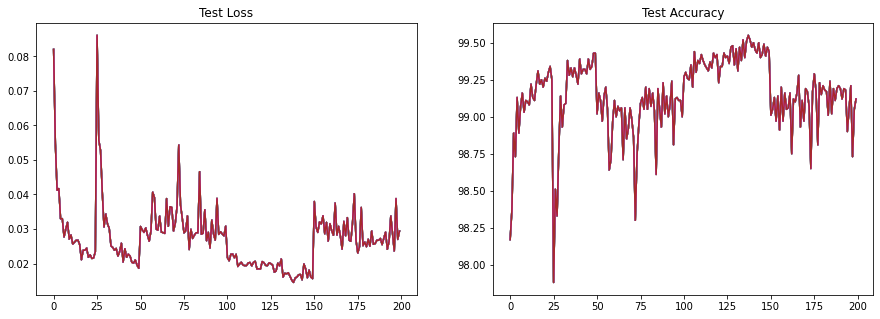

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
for i in range(1,9):
  if i == 1:
    print("CASE_1: without L1andL2 with BN")

    axs[0].plot(results1[0],color='red')
    axs[0].set_title("Test Loss")
    axs[1].plot(results1[1],color='red')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 2:
    print("CASE_2: without L1andL2 with GBN")
    
    axs[0].plot(results2[0],color='green')
    axs[0].set_title("Test Loss")
    axs[1].plot(results2[1],color='green')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 3:
    print("CASE_3: with L1 with BN")
    
    axs[0].plot(results3[0],color='blue')
    axs[0].set_title("Test Loss")
    axs[1].plot(results3[1],color='blue')
    axs[1].set_title("Test Accuracy123")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 4:
    print("CASE_4: with L1 with GBN")
    
    axs[0].plot(results4[0], color='black')
    axs[0].set_title("Test Loss")
    axs[1].plot(results4[1], color='black')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 5:
    print("CASE_5: with L2 with BN")
    
    axs[0].plot(results5[0], color='yellow')
    axs[0].set_title("Test Loss")
    axs[1].plot(results5[1], color='yellow')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 6:
    print("CASE_6: with L2 with GBN")
    
    axs[0].plot(results6[0], color='cyan')
    axs[0].set_title("Test Loss")
    axs[1].plot(results6[1], color='cyan')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 7:
    print("CASE_7: with L1andL2 with BN")
    
    axs[0].plot(results7[0], color='magenta')
    axs[0].set_title("Test Loss")
    axs[1].plot(results7[1], color='magenta')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 8:
    print("CASE_8: with L1andL2 with GBN")
    
    axs[0].plot(results8[0], color='brown')
    axs[0].set_title("Test Loss")
    axs[1].plot(results8[1], color='brown')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')